In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import copy
import pickle
import sys
import os
import math

import pytorch_lightning as pl

import logging

sys.path.insert(0, 'C:\\Users\\peter\\anaconda3\\envs\\cv\\Scripts\\ptls-glove')

from functools import partial
from ptls.nn import RnnSeqEncoder, TrxEncoder
from ptls.nn.trx_encoder.trx_encoders_custom import TrxEncoderGlove, TrxEncoderCat
from ptls.preprocessing.baseline_discretizer import KDiscretizer, SingleTreeDiscretizer
from ptls.preprocessing.deeptlf import DeepTLFDisc
from ptls.frames.coles import CoLESModule
from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.frames.coles import ColesDataset
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames import PtlsDataModule, TestModule
from ptls.frames.coles.metric import BatchRecallTopK

import ptls
import torch
from torch import nn
from ptls.preprocessing import PandasDataPreprocessor
from sklearn.model_selection import train_test_split
from ptls.data_load.datasets import inference_data_loader
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

2025-02-10 12:03:15.740952: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-10 12:03:15.756981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739178195.776422    6756 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739178195.782270    6756 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-10 12:03:15.801819: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def prepare_data_age_bins_scenario():
    data_path = '../data/age_bins'

    source_data = pd.read_csv(os.path.join(data_path, 'transactions_train.csv'))

    df_params = {
        "numeric_cols" : ["amount_rur"],
        "cat_cols" : ["small_group"],
        "date_col" : "trans_date",
        "cat_unique" : [],
        "id_col" : "client_id"
    }

    for f in df_params["cat_cols"] + [df_params["date_col"]]:
        df_params["cat_unique"].append(source_data[f].unique().shape[0])

    return source_data, df_params

def prepare_data_gender_scenario():
    data_path = '../data/gender'

    source_data = pd.read_csv(os.path.join(data_path, 'transactions.csv'))
    source_data = source_data.drop(columns=["term_id"]).rename(columns={'customer_id' : 'client_id'})

    source_data.tr_datetime = [int(i.split()[0]) for i in source_data.tr_datetime.values]

    df_params = {
        "numeric_cols" : ["amount"],
        "cat_cols" : ["mcc_code", "tr_type"],
        "cat_unique" : [],
        "date_col" : "tr_datetime",
        "id_col" : "client_id"
    }

    for f in df_params["cat_cols"] + [df_params["date_col"]]:
        df_params["cat_unique"].append(source_data[f].unique().shape[0])
    
    return source_data, df_params

In [8]:
#age bins
TARGET_NAME = 'bins'
source_data, df_params = prepare_data_age_bins_scenario()
targets = pd.read_csv(os.path.join('../data/age_bins', 'train_target.csv'))
source_data.head(2)

,client_id,trans_date,small_group,amount_rur
0,33172,6,4,71.463
1,33172,6,35,45.017


In [3]:
#gender
TARGET_NAME = 'gender'
source_data, df_params = prepare_data_gender_scenario()
#targets = pd.read_csv(os.path.join('../data/gender', 'gender_train.csv')).drop(columns=['Unnamed: 0'])
targets = pd.read_csv(os.path.join('../data/gender', 'gender_train.csv')).rename(columns={'customer_id' : 'client_id'})
targets = source_data[['client_id']].drop_duplicates().merge(targets, on='client_id', how='left').fillna(2)
source_data.head(2)

,client_id,tr_datetime,mcc_code,tr_type,amount
0,39026145,0,4814,1030,-2245.92
1,39026145,1,6011,7010,56147.89


In [9]:
EMBED_SIZE = 16

disc_quant100 = KDiscretizer(
    f_names = df_params['numeric_cols'],
    k_bins = 100,
    d_type = 'quantile'
)

disc_uni100 = KDiscretizer(
    f_names = df_params['numeric_cols'],
    k_bins = 100,
    d_type = 'uniform'
)

disc_kmeans100 = KDiscretizer(
    f_names = df_params['numeric_cols'],
    k_bins = 100,
    d_type = 'kmeans'
)

disc_st100 = SingleTreeDiscretizer(
    f_names = df_params['numeric_cols'], 
    target_name = TARGET_NAME, 
    target_type = 'classification', 
    k_bins = [100],
)

disc_quant20 = KDiscretizer(
    f_names = df_params['numeric_cols'],
    k_bins = 20,
    d_type = 'quantile',
)

disc_uni20 = KDiscretizer(
    f_names = df_params['numeric_cols'],
    k_bins = 20,
    d_type = 'uniform',
)

disc_kmeans20 = KDiscretizer(
    f_names = df_params['numeric_cols'],
    k_bins = 20,
    d_type = 'kmeans',
)

disc_st20 = SingleTreeDiscretizer(
    f_names = df_params['numeric_cols'], 
    target_name = TARGET_NAME, 
    target_type = 'classification', 
    k_bins = [20],
)

deeptlf3 = DeepTLFDisc({"n_est" : 3,
                  "min_freq" : 2,
                  "features" : df_params['numeric_cols'] + df_params['cat_cols'],
                  "features_to_split" : df_params['numeric_cols']
                  })
deeptlf6 = DeepTLFDisc({"n_est" : 6,
                  "min_freq" : 2,
                  "features" : df_params['numeric_cols'] + df_params['cat_cols'],
                  "features_to_split" : df_params['numeric_cols'],
                  })
deeptlf9 = DeepTLFDisc({"n_est" : 9,
                  "min_freq" : 2,
                  "features" : df_params['numeric_cols'] + df_params['cat_cols'],
                  "features_to_split" : df_params['numeric_cols'],
                  })
discs = {
    'quant100' : disc_quant100,
    'uni100' : disc_uni100,
    'kmeans100' : disc_kmeans100,
    'st100' : disc_st100,
    'quant20' : disc_quant20,
    'uni20' : disc_uni20,
    'kmeans20' : disc_kmeans20,
    'st20' : disc_st20,
    'deeptlf3' : deeptlf3,
    'deeptlf6' : deeptlf6,
    'deeptlf9' : deeptlf9,
}

In [10]:
cat_distr = {}
tresholds = {}

for fn in df_params['numeric_cols']:
    tresholds[fn] = {}
    cat_distr[fn] = {}

for dn in tqdm(discs.keys()):
    data = copy.deepcopy(source_data)
    if dn[:2] != "st":
        discs[dn].fit(data)
        data = discs[dn].transform(data, to_embeds=False)
    else:
        discs[dn].fit(data.sample(int(1e+5), random_state=42).merge(targets, on=df_params['id_col'], how='left'))
        data = discs[dn].transform(data, to_embeds=False)

    for fn in df_params['numeric_cols']:
        
        tresholds[fn][dn] = discs[dn].tresholds[fn]
        cat_distr[fn][dn] = data.groupby(fn).agg({'client_id' : 'count'}).rename(columns={'client_id' : 'cnt'})
        cat_distr[fn][dn].cnt /= data.shape[0] 

  0%|          | 0/11 [00:00<?, ?it/s]

amount_rur:   0%|          | 0/15 [00:00<?, ?it/s]

amount_rur:   0%|          | 0/15 [00:00<?, ?it/s]

Counter({'small_group': 54, 'amount_rur': 27})
Counter({'small_group': 108, 'amount_rur': 42})
Counter({'small_group': 153, 'amount_rur': 62})


In [11]:
def plot_tresholds(t_list, dns, ds_name, scale='linear'):
    plt.figure(figsize=(10, 5))
    
    for i, t in enumerate(t_list):
        x_values = t
        y_values = [i] * len(t)
        plt.scatter(x_values, y_values, label=f'{dns[i]} disc')
    
    plt.xscale(scale)
    plt.xlabel('Values (log scale)')
    plt.title(f'Tresholds, {ds_name} dataset')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def plot_category_histograms(dns, distrs):
    num_plots = len(distrs)
    rows = math.ceil(math.sqrt(num_plots))
    cols = math.ceil(num_plots / rows)
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows))
    axes = axes.flatten() if num_plots > 1 else [axes]

    i = 0
    for ax, df in zip(axes, distrs):
        ax.bar(df.index, df.cnt, color='skyblue')
    
        ax.set_xlabel('Bin')
        ax.set_ylabel('Share')
        ax.set_title(f'{dns[i]}')
        ax.set_xticks(df.index)
        ax.set_xticklabels(df.index, rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        i += 1
    
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

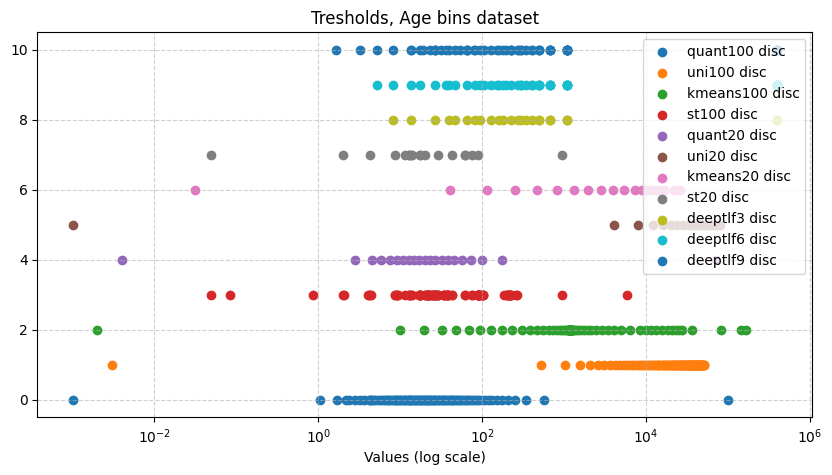

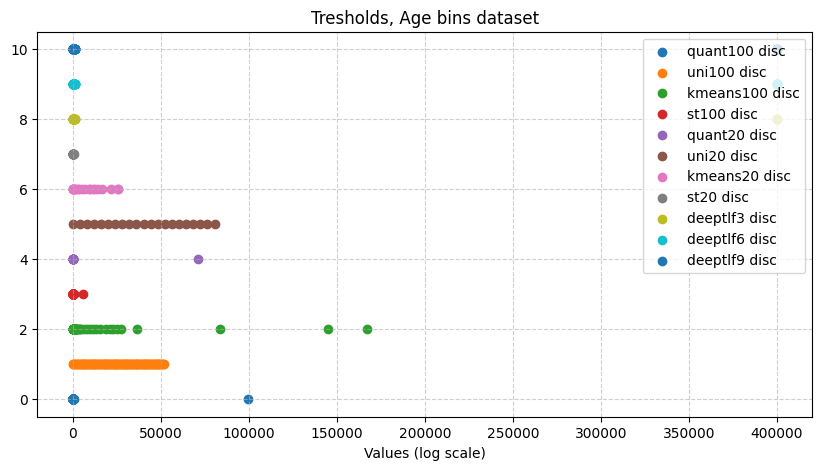

In [17]:
#AGE BINS DATASET TRESHOLDS DIST

dns = list(tresholds[df_params['numeric_cols'][0]].keys())
ts = [tresholds[df_params['numeric_cols'][0]][i] for i in dns]

plot_tresholds(ts, dns, "Age bins", scale='log')
plot_tresholds(ts, dns, "Age bins", scale='linear')


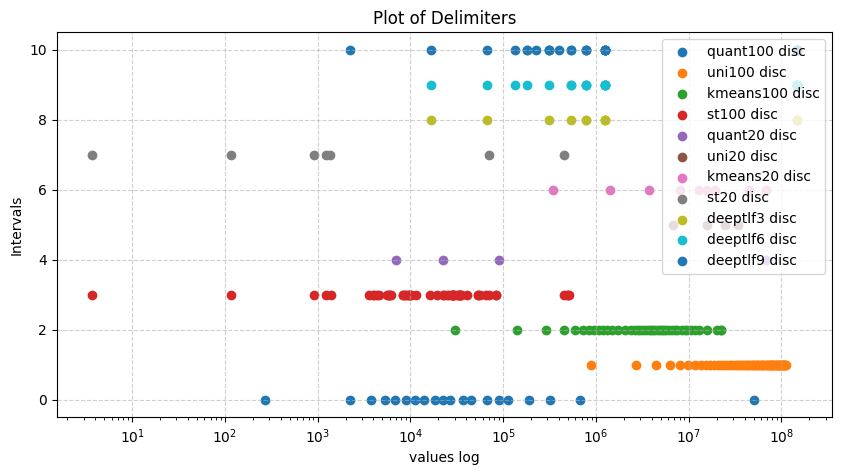

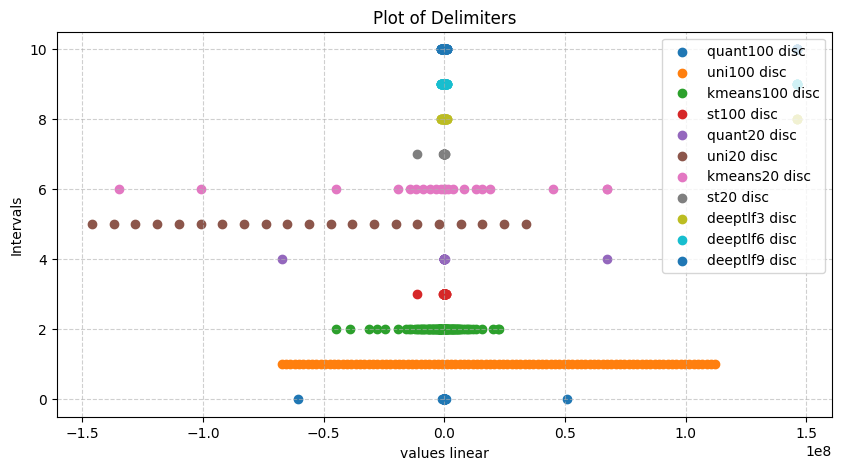

In [9]:
#GENDER DATASET TRESHOLDS DIST

dns = list(tresholds[df_params['numeric_cols'][0]].keys())
ts = [tresholds[df_params['numeric_cols'][0]][i] for i in dns]

plot_tresholds(ts, dns, "Gender", scale='log')
plot_tresholds(ts, dns, "Gender", scale='linear')

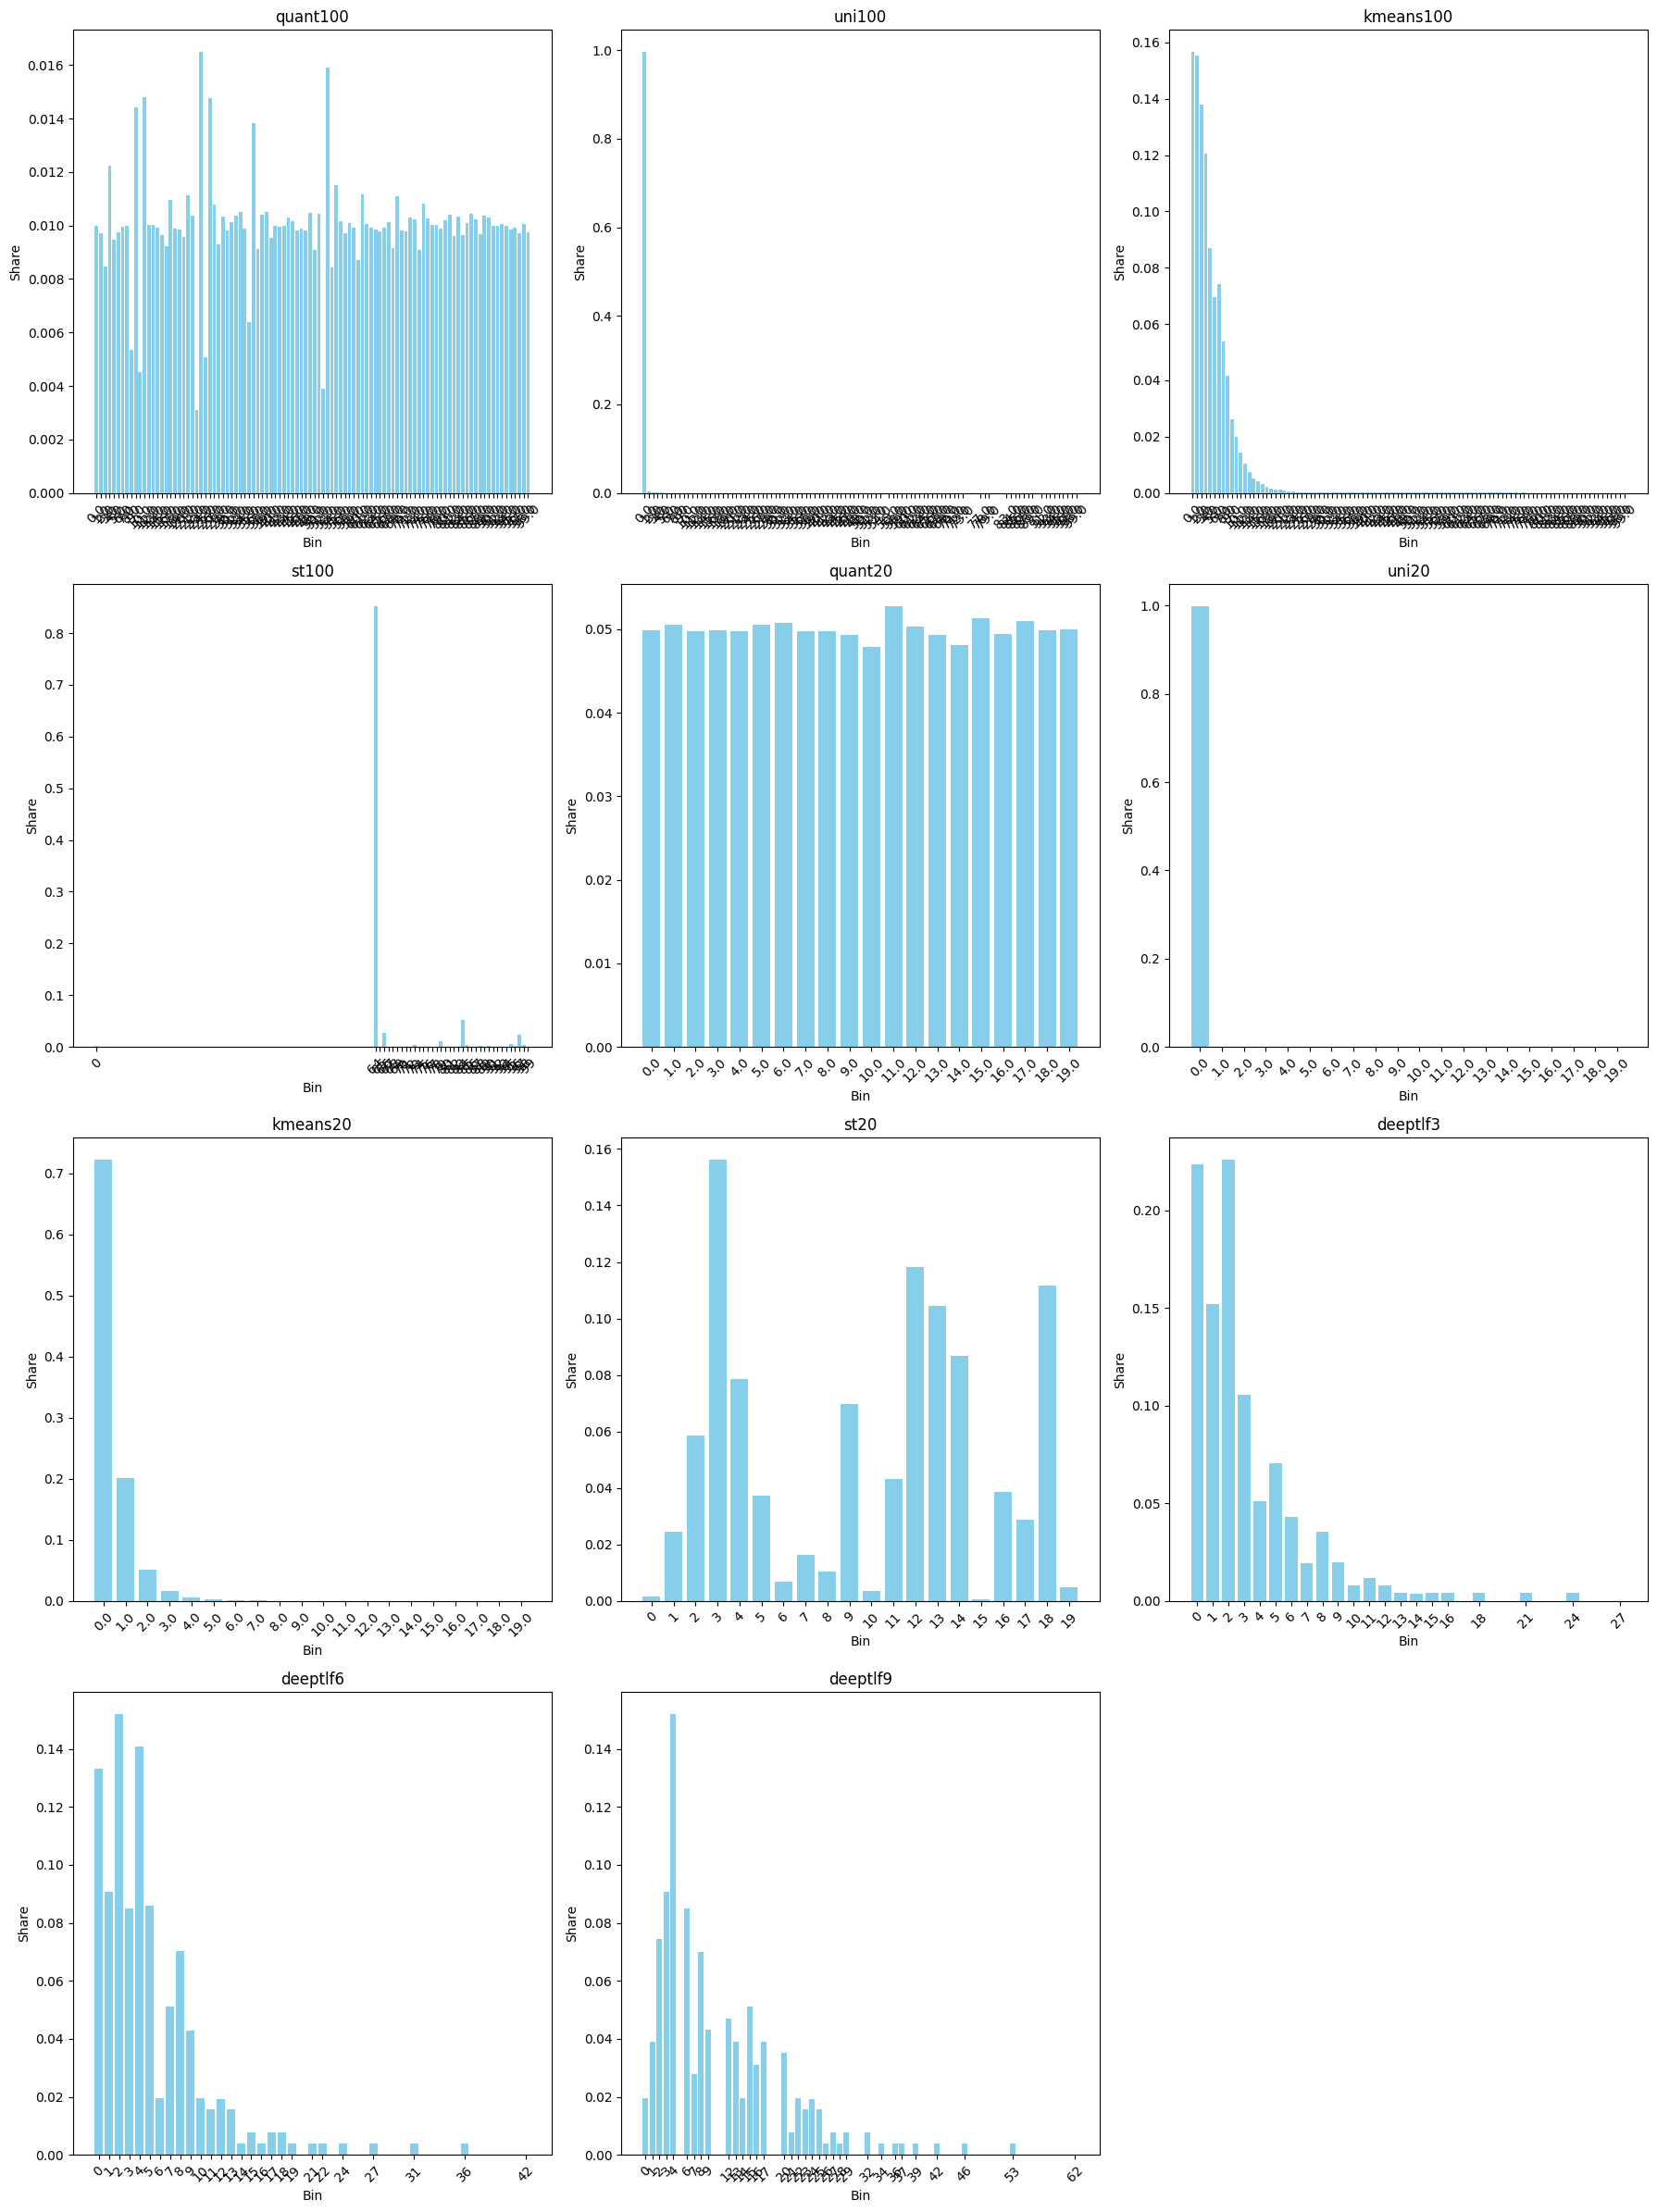

In [12]:
#AGE BINS DATASET VALUES DIST

dns = list(cat_distr['amount_rur'].keys())
distrs = [cat_distr['amount_rur'][nm] for nm in dns]

plot_category_histograms(dns, distrs)

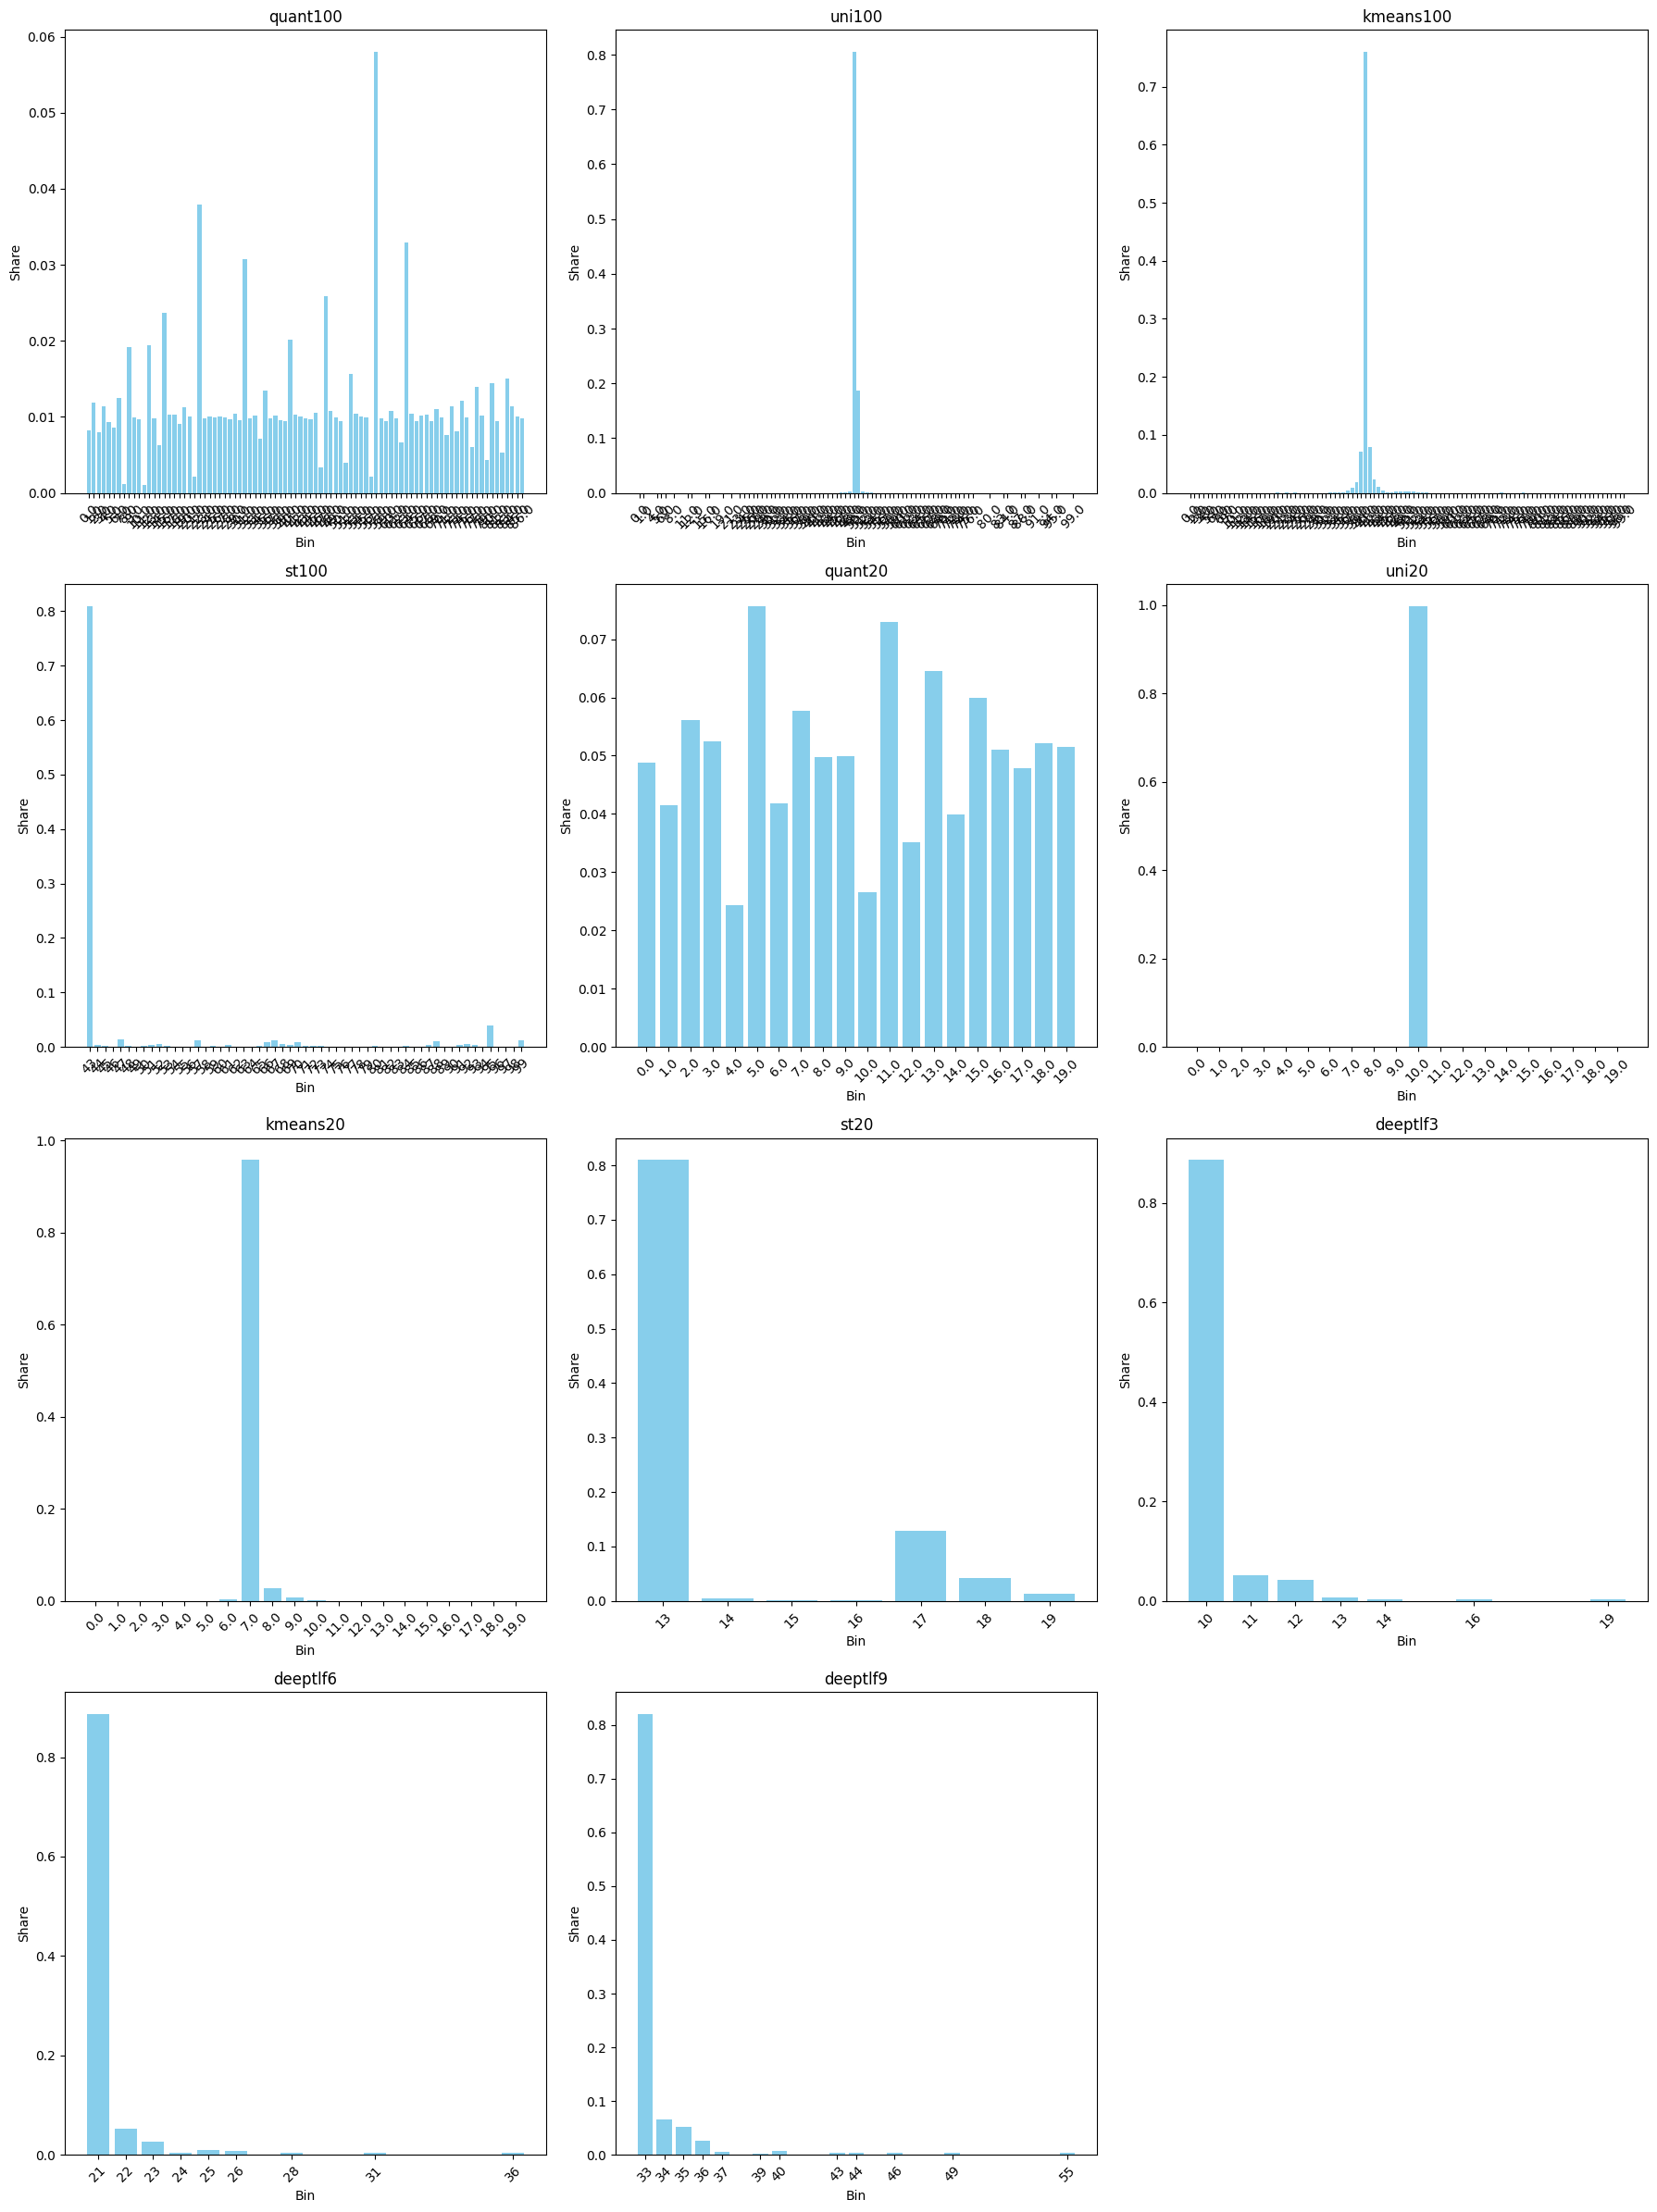

In [7]:
#GENDER DATASET VALUES DIST

dns = list(cat_distr[df_params['numeric_cols'][0]].keys())
distrs = [cat_distr[df_params['numeric_cols'][0]][nm] for nm in dns]

plot_category_histograms(dns, distrs)